# Text-to-Image Generation using Stable Diffusion (Project)

## Hybrid Pipeline: Stable Diffusion + GAN Simulation + CGAN
This notebook implements all required modules:
- Text Preprocessing & Embedding (Transformers)
- Conditional GAN with category embeddings
- Stable Diffusion generation and simulated domain fine-tuning
- Public dataset analysis (Oxford-102 Flowers)
- End-to-end UI with Gradio

## Import Libraries
##### We import PyTorch for model execution, `diffusers` for the Stable Diffusion model, and Gradio for the web interface.


In [55]:
import torch
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA version: {torch.version.cuda}')

PyTorch version: 2.4.1+cpu
CUDA version: None


In [56]:
if torch.cuda.is_available():
  print(f'cuda device name: {torch.cuda.get_device_name(0)}')
  print(f'GPU name: {torch.cuda.get_device_name(0)}')

In [57]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F

## Load the Stable Diffusion Model
### We load the pretrained **Stable Diffusion Pipeline** from Hugging Face.
#### This model takes a text prompt as input and outputs a generated image.


In [58]:
import torch
import torch_directml

print("torch:", torch.__version__)
dml = torch_directml.device()
x = torch.randn(2,2, device=dml)
print("Device:", x.device)


torch: 2.4.1+cpu
Device: privateuseone:0


In [59]:
from diffusers import StableDiffusionPipeline
import gradio as gr
from PIL import Image

In [61]:
print(f"Pytorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available}")
print(f'GPU device:{torch.cuda.get_device_name(0) if torch.cuda.is_available() else "no GPU"}')

Pytorch version: 2.4.1+cpu
CUDA available: <function is_available at 0x000001A7F434CB80>
GPU device:no GPU


In [62]:
from dataclasses import dataclass
from typing import List, Union, Tuple, Dict
import torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

@dataclass
class EmbedderConfig:
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    device: str = "auto"
    max_length: int = 64
    batch_size: int = 16
    normalize: bool = True

class TextEmbedder:
    def __init__(self, config: EmbedderConfig = EmbedderConfig()):
        self.config = config
        self.device = ("cuda" if torch.cuda.is_available() else "cpu") if config.device=="auto" else config.device
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(config.model_name).to(self.device).eval()

    @torch.no_grad()
    def encode(self, texts: Union[str, List[str]]):
        if isinstance(texts, str): texts=[texts]
        toks = self.tokenizer(texts, padding=True, truncation=True,
                              max_length=self.config.max_length, return_tensors='pt')
        toks = {k:v.to(self.device) for k,v in toks.items()}
        out = self.model(**toks).last_hidden_state        # (B,T,H)
        mask = toks['attention_mask'].unsqueeze(-1).expand_as(out).float()
        pooled = (out*mask).sum(1) / mask.sum(1).clamp_min(1e-6)   # mean-pool
        if self.config.normalize:
            pooled = F.normalize(pooled, p=2, dim=-1)
        # return vectors + some simple metadata
        return pooled.detach().cpu(), texts, {"lengths": toks['attention_mask'].sum(-1).cpu().tolist()}


In [63]:
import torch
from diffusers import StableDiffusionPipeline

_SD_PIPE = None
_EMBEDDER = None
_CGAN = None

def _get_sd(model_id="runwayml/stable-diffusion-v1-5"):
    global _SD_PIPE
    if _SD_PIPE is None:
        dtype = torch.float16 if torch.cuda.is_available() else torch.float32
        _SD_PIPE = StableDiffusionPipeline.from_pretrained(
            model_id, torch_dtype=dtype, safety_checker=None, requires_safety_checker=False
        )
        _SD_PIPE.to("cuda" if torch.cuda.is_available() else "cpu")
    return _SD_PIPE

def _get_embedder():
    global _EMBEDDER
    if _EMBEDDER is None:
        _EMBEDDER = TextEmbedder(EmbedderConfig())
    return _EMBEDDER

def _get_cgan():
    global _CGAN
    if _CGAN is None:
        _CGAN = ConceptualCGAN(num_categories=3)
    return _CGAN

def ui_generate(model_choice, prompt, category, width, height, seed):
    if "Stable Diffusion" in model_choice:
        pipe = _get_sd()
        g = torch.Generator(device=pipe.device).manual_seed(int(seed))
        out = pipe(prompt, width=int(width), height=int(height),
                   num_inference_steps=30, guidance_scale=7.5, generator=g)
        return out.images[0]
    else:
        cgan = _get_cgan()
        emb = _get_embedder()
        return render_cgan_sample(cgan, category_id=int(category), text=prompt,
                                  embedder=emb, size=(int(width), int(height)), seed=int(seed))

from datasets import load_dataset
from PIL import Image

def ui_dataset_preview(dataset_id="huggan/oxford-102-flowers"):
    ds = load_dataset(dataset_id, split="train", trust_remote_code=True)
    n = len(ds)
    cols = list(ds.features.keys())
    sample = ds.shuffle(seed=42)[0]
    img = sample.get("image", None)
    if img is None:
        for v in sample.values():
            if hasattr(v, "convert"):
                img = v; break
    stats = {"Total Samples": n, "Columns": cols[:8]}
    return (img.convert("RGB") if img is not None else None), str(stats)


## Generate Images from Text Prompts
We can now provide any text prompt, such as *"A cat playing guitar in space"*, and the model will generate a matching image.


In [64]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from torch import autocast
import numpy as np
from PIL import Image
import os
import time
import gc
from typing import Optional, Tuple, List, Dict
from datetime import datetime
import gradio as gr
import re
import torch.nn as nn # for GAN simulation
from transformers import AutoTokenizer, AutoModel # for Text Embedding
from datasets import load_dataset


from diffusers import (
    StableDiffusionPipeline,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
    DDIMScheduler,
    LMSDiscreteScheduler
)

## Text Preprocessing & Embedding using Transformers
This section cleans text, tokenizes it, and encodes using CLIP / HuggingFace models.

In [65]:
class TextEncoderModule:
    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        """Initializes a simple text tokenizer and encoder"""
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.encoder = AutoModel.from_pretrained(model_name)
            self.embed_dim = self.encoder.config.hidden_size
        except Exception:
            self.tokenizer = None
            self.encoder = None
            self.embed_dim = 512
            self.max_length = 77

    def preprocess_text(self, text: str) -> str:
        """Performs simple text cleaning."""
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip().lower()
        return text

    def create_embedding(self, prompt: str, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """Tokenizes, encodes, and returns the text embedding sequence and context vector."""

        # 1. Text Preprocessing :-
        cleaned_prompt = self.preprocess_text(prompt)

        # 2. Text Embedding Creation :-
        if self.encoder is not None:
            self.encoder.to(device)
            inputs = self.tokenizer(
                cleaned_prompt,
                padding="max_length",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                outputs = self.encoder(**inputs)
                token_embeddings_sequence = outputs.last_hidden_state.squeeze(0)
                context_vector = token_embeddings_sequence.mean(dim=0)
        else:
            token_embeddings_sequence = torch.randn(77, self.embed_dim).to(device)
            context_vector = token_embeddings_sequence.mean(dim=0)

        metadata = {
            "prompt": prompt,
            "cleaned_prompt": cleaned_prompt,
            "embed_dim": self.embed_dim,
            "sequence_length": token_embeddings_sequence.shape[0]
        }
        return token_embeddings_sequence, context_vector, metadata

In [66]:
encoder = TextEncoderModule(model_name="laion/CLIP-ViT-B-32-laion2B-s34B-b79K")
tokens, sent, meta = encoder.create_embedding("a beautiful mountain landscape at sunset", torch.device("cpu"))

print("Token Embeddings:", tokens.shape)
print("Sentence Embedding:", sent.shape)
print("Metadata:", meta)

Token Embeddings: torch.Size([77, 512])
Sentence Embedding: torch.Size([512])
Metadata: {'prompt': 'a beautiful mountain landscape at sunset', 'cleaned_prompt': 'a beautiful mountain landscape at sunset', 'embed_dim': 512, 'sequence_length': 77}


In [67]:
class ConceptualCGAN(nn.Module):
    def __init__(self, num_categories: int = 3, text_embed_dim: int = 512):
        super().__init__()
        self.num_categories = num_categories
        
        self.category_embedding = nn.Embedding(num_categories, 50)

        self.text_proj = nn.Linear(text_embed_dim, 128, bias=False)

        self.initial_latent_size = 50 + 128 + 128 
        self.initial_map_size = 512
        self.output_channels = 3
        
        self.main = nn.Sequential(
            nn.Linear(self.initial_latent_size, self.initial_map_size),
            nn.BatchNorm1d(self.initial_map_size),
            nn.ReLU(True),
            nn.Linear(self.initial_map_size, 512*512 * self.output_channels),
            nn.Tanh()
        )

    def conceptual_cross_attention(self, token_sequence: torch.Tensor, context_vector: torch.Tensor) -> torch.Tensor:
        """Simulates the attention mechanism."""
        Q = self.attention_projection_q(context_vector.unsqueeze(0).unsqueeze(0))
        K = self.attention_projection_k(token_sequence.unsqueeze(0))
        V = self.attention_projection_v(token_sequence.unsqueeze(0))

        attention_scores = torch.bmm(Q, K.transpose(1, 2))
        attention_weights = F.softmax(attention_scores / (self.text_embed_dim ** 0.5), dim=-1)
        attended_features = torch.bmm(attention_weights, V).squeeze(1)
        attended_latent = self.attention_output_proj(attended_features)

        return attended_latent.squeeze(0)

    def forward(self, category_id: torch.Tensor, text_embedding: torch.Tensor, width: int, height: int) -> torch.Tensor:
        
        # 1. Category Embedding:-
        cat_emb = self.category_embedding(category_id)

        # 2. Project text embedding to 128 dims:-
        txt_emb = self.text_proj(text_embedding)

        # 3. Noise vector:-
        noise = torch.randn(category_id.shape[0], 128).to(category_id.device)

        # 4. Combine all:-
        latent = torch.cat((cat_emb, txt_emb, noise), dim=1)

        # 5. Generate:-
        fake_flat = self.main(latent)
        fake = fake_flat.view(category_id.shape[0], self.output_channels, 512, 512)

        if width != 512 or height != 512:
            fake = F.interpolate(fake, size=(height, width), mode='bilinear', align_corners=False)
            
        return fake

## Pre-trained Text-to-Image Model (Stable Diffusion)
Loads SD 1.5 / 2.1 / RealVis, supports schedulers, seeds, saving images.


In [68]:
class StableDiffusionGenerator:
    def __init__(self, model_id: str, device: str = "auto"):
        self.device = self._setup_device(device)
        self.dtype = torch.float16 if self.device.type == "cuda" else torch.float32
        self.pipe = self._load_pipeline(model_id)
        self.current_scheduler = "euler_a"
        self.schedulers = {
            "euler_a": ("Euler Ancestral", "Fast, good for creative images"),
            "euler": ("Euler", "Deterministic, consistent results"),
            "ddim": ("DDIM", "Classic, good quality, slower"),
            "dpm_solver": ("DPM Solver", "High quality, efficient"),
            "lms": ("LMS", "Linear multistep, stable")
        }
        print("Stable Diffusion Generator Ready!")

    # Setup Methods :-
    def _setup_device(self, device: str) -> torch.device:
        if device == "auto":
            if torch.cuda.is_available():
                device = "cuda"
            else:
                device = "cpu"
        return torch.device(device)

    def _load_pipeline(self, model_id: str) -> StableDiffusionPipeline:
        try:
            pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                dtype=self.dtype,                   
                safety_checker=None,
                requires_safety_checker=False,
            )
    
            if hasattr(pipe, "enable_attention_slicing"): pipe.enable_attention_slicing()
            if hasattr(pipe, "enable_vae_slicing"):       pipe.enable_vae_slicing()
            try:
                if hasattr(pipe, "enable_xformers_memory_efficient_attention"):
                    pipe.enable_xformers_memory_efficient_attention()
            except Exception:
                pass 
    
            if self.device.type == "cuda":
                # GPU path
                pipe = pipe.to(self.device)
                try:
                    pipe.enable_model_cpu_offload()
                except Exception:
                    pass
            else:
                pipe = pipe.to("cpu")
    
            return pipe
    
        except Exception as e:
            raise RuntimeError(f"Failed to load Diffusion model: {e}")


    # Scheduler & Generation :-
    def set_scheduler(self, scheduler_name: str) -> bool:
        if scheduler_name not in self.schedulers:
            return False
        if scheduler_name == self.current_scheduler:
            return True

        scheduler_map = {
            "euler_a": EulerAncestralDiscreteScheduler,
            "euler": EulerDiscreteScheduler,
            "ddim": DDIMScheduler,
            "dpm_solver": DPMSolverMultistepScheduler,
            "lms": LMSDiscreteScheduler
        }
        try:
            scheduler_class = scheduler_map[scheduler_name]
            self.pipe.scheduler = scheduler_class.from_config(self.pipe.scheduler.config)
            self.current_scheduler = scheduler_name
            return True
        except Exception:
            return False

    def generate_image(
        self,
        prompt: str,
        negative_prompt: str = "",
        width: int = 512,
        height: int = 512,
        num_inference_steps: int = 20,
        guidance_scale: float = 7.5,
        seed: Optional[int] = None,
        scheduler: str = "euler_a"
    ) -> Tuple[Image.Image, dict]:

        self.set_scheduler(scheduler)
        if seed is None:
            seed = torch.randint(0, 2**32, (1,)).item()

        generator = torch.Generator(device=self.device)
        generator.manual_seed(seed)

        width = (width // 8) * 8
        height = (height // 8) * 8

        start_time = time.time()
        try:
            with torch.inference_mode():
                context = autocast(self.device.type) if self.device.type == "cuda" and self.dtype == torch.float16 else torch.no_grad()
                with context:
                    result = self.pipe(
                        prompt=prompt,
                        negative_prompt=negative_prompt if negative_prompt else None,
                        width=width,
                        height=height,
                        num_inference_steps=num_inference_steps,
                        guidance_scale=guidance_scale,
                        generator=generator
                    )

            generation_time = time.time() - start_time
            metadata = {
                "model_type": "Diffusion",
                "prompt": prompt,
                "negative_prompt": negative_prompt,
                "width": width,
                "height": height,
                "steps": num_inference_steps,
                "guidance_scale": guidance_scale,
                "scheduler": scheduler,
                "seed": seed,
                "generation_time": round(generation_time, 2),
                "device": str(self.device),
                "dtype": str(self.dtype)
            }
            return result.images[0], metadata

        except Exception as e:
            self._cleanup_memory()
            raise RuntimeError(f"Diffusion Generation failed: {str(e)}")
        finally:
            self._cleanup_memory()

    def _cleanup_memory(self):
        gc.collect()
        if self.device.type == "cuda":
            torch.cuda.empty_cache()

    def get_memory_usage(self) -> dict:
        memory_info = {}
        if self.device.type == "cuda":
            memory_info = {
                "allocated_gb": torch.cuda.memory_allocated() / 1024**3,
                "reserved_gb": torch.cuda.memory_reserved() / 1024**3,
                "max_allocated_gb": torch.cuda.max_memory_allocated() / 1024**3,
                "total_gb": torch.cuda.get_device_properties(0).total_memory / 1024**3
            }
        else:
            memory_info = {"device": "cpu", "note": "CPU memory tracking not available"}
        return memory_info

    def save_image(self, image: Image.Image, metadata: dict, output_dir: str = "outputs") -> str:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{metadata['model_type'].lower()}_gen_{timestamp}_s{metadata['seed']}_{metadata['width']}x{metadata['height']}.png"
        filepath = os.path.join(output_dir, filename)
        image.save(filepath)

        metadata_file = filepath.replace('.png', '_metadata.txt')
        with open(metadata_file, 'w') as f:
            f.write("Text-to-Image Generation Metadata\n")
            f.write("=" * 40 + "\n")
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")
        return filepath

In [69]:
class DomainRefinerModule:
    def __init__(self):
        self.domains = {
            "Medical X-Ray (Synthetic)": "A dataset of synthetic CT/MRI scans annotated with anatomical terms.",
            "Abstract Oil Painting (Style)": "A small dataset of high-resolution abstract oil paintings from a single artist's portfolio.",
            "High-Res Product Photography": "A curated set of product images with studio lighting and minimalist captions."
        }
        self.trained_loras = {}

    def get_domain_datasets(self) -> List[str]:
        return list(self.domains.keys())

    def run_lora_training(self, domain_name: str, base_model_id: str, steps: int = 1000) -> Dict:
        """Simulates the lightweight fine-tuning process."""
        if domain_name not in self.domains:
            return {"status": "Error", "message": f"Domain '{domain_name}' not recognized."}

        dataset_info = self.domains[domain_name]

        lora_id = f"{domain_name.lower().replace(' ', '_')}_lora"
        self.trained_loras[domain_name] = lora_id

        metadata = {
            "status": "Success",
            "message": f"Simulated fine-tuning complete. LoRA adapter created and stored.",
            "lora_adapter_id": lora_id,
            "base_model": base_model_id,
            "simulated_steps": steps,
            "training_technique": "LoRA (Low-Rank Adaptation)",
            "domain_dataset": dataset_info
        }

        return metadata

refiner = DomainRefinerModule()

## Public Dataset Analysis (Oxford-102 Flowers)
Loads dataset, checks samples, computes stats, previews sample images.


In [70]:
class DatasetAnalyzer:
    def __init__(self):
        self.dataset_id = "huggan/oxford-102-flowers"
        self.dataset = None
        self.analysis_results = {}

    def load_and_analyze(self) -> Dict:
        """Loads the dataset and performs statistical analysis."""

        try:
            from datasets import load_dataset
            self.dataset = load_dataset(self.dataset_id, split="train", trust_remote_code=True)
        except Exception as e:
            return {"status": "Error", "message": f"Failed to load dataset: {str(e)}"}

        num_samples = len(self.dataset)
        num_classes = len(self.dataset.unique("label"))
        
        description_lengths = [len(s['text'].split()) for s in self.dataset if s['text']]

        avg_desc_length = np.mean(description_lengths) if description_lengths else 0
        min_desc_length = np.min(description_lengths) if description_lengths else 0
        max_desc_length = np.max(description_lengths) if description_lengths else 0

        sample_image = self.dataset[0]['image']
        avg_resolution = f"{sample_image.width} x {sample_image.height}"

        self.analysis_results = {
            "status": "Success",
            "message": f"Analysis complete for {self.dataset_id}.",
            "Total Samples": num_samples,
            "Number of Classes": num_classes,
            "Avg. Description Length (Words)": f"{avg_desc_length:.1f}",
            "Min Description Length (Words)": min_desc_length,
            "Max Description Length (Words)": max_desc_length,
            "Sample Image Resolution": avg_resolution
        }

        return self.analysis_results

    def get_sample_data(self, num_samples: int = 3) -> Tuple[List[Image.Image], str]:
        """Retrieves and formats sample images and descriptions."""

        if self.dataset is None:
            return [], "Error: Dataset not loaded. Please run 'Load and Analyze' first."

        samples = self.dataset.shuffle(seed=42).select(range(num_samples))

        image_list = []
        text_info = "--- Sample Data ---\n"

        for i, sample in enumerate(samples):
            image_list.append(sample['image'])
            text_info += f"Sample {i+1} (Class: {sample['label']}):\n"
            text_info += f"    Description: '{sample['text'][:100]}...'\n"

        return image_list, text_info

analyzer = DatasetAnalyzer()

## Conditional GAN / CGAN Simulation
- Implements category embeddings
- Uses noise + condition to generate images
- Includes simplified cross-attention block (for GAN)


In [71]:
class CGANTool:
    def __init__(self, device: torch.device, text_embed_dim=512):
        self.categories = {0: "Circle", 1: "Square", 2: "Triangle"}
        self.device = device

        self.generator = ConceptualCGAN(num_categories=len(self.categories), text_embed_dim=text_embed_dim).to(device)
        self.generator.eval()
        for p in self.generator.parameters():
            p.requires_grad_(False)

        self.text_encoder = None 

    def attach_text_encoder(self, encoder):
        """Attach TextEncoderModule so CGAN can use text"""
        self.text_encoder = encoder

    def generate_image(self, category_name: str, text: str, width: int, height: int, seed: Optional[int] = None):
        category_name_norm = category_name.strip().title()
        if category_name_norm not in self.categories.values():
            raise ValueError(f"Invalid category: {category_name_norm}. Choose from: {list(self.categories.values())}")
    
        if self.text_encoder is not None and text and text.strip():
            _ = self.text_encoder.create_embedding(text, self.device)
    
        import time
        start_time = time.time()
        img = _render_shape_image(category_name_norm, text, width, height, seed)  
        gen_time = time.time() - start_time
    
        metadata = {
            "model_type": "CGAN Simulation",
            "category": category_name_norm,
            "text": text,
            "conditioning": "Category + Text (procedural)",
            "condition": f"Category: {category_name_norm} | Text: {text}",
            "conditioning_technique": "Procedural shape rendering; color/size derived from text",
            "width": width,
            "height": height,
            "seed": seed if seed is not None else "Random",
            "generation_time": round(gen_time, 2),
            "device": str(self.device),
        }
        return img, metadata

In [72]:
import torch, torch.nn as nn
from PIL import Image
import numpy as np
from typing import Tuple

def render_cgan_sample(cgan, category_id:int=0, text:str=None,
                       embedder=None, size:Tuple[int,int]=(256,256), seed:int=42):
    torch.manual_seed(seed)
    w,h = size

    if embedder and text:
        emb, _, _ = embedder.encode(text)
        if emb.shape[-1] != 128:
            proj = nn.Linear(emb.shape[-1], 128, bias=False)
            with torch.no_grad():
                emb = proj(emb)
        z = torch.randn(1, 50)
        latent = torch.cat([z, emb.float()], dim=-1)
    else:
        latent = torch.randn(1, 50+128)

    with torch.no_grad():
        x = cgan.main(latent) 
        img = x.view(1, cgan.output_channels, 512, 512)
        img = (img.clamp(-1,1) + 1)/2.0
        img = nn.functional.interpolate(img, size=(h,w), mode='bilinear', align_corners=False)
        arr = (img[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    return Image.fromarray(arr)


In [73]:
class StableDiffusionUI:
    def __init__(self):
        self.diffusion_generator = None
        self.gan_generator = None
        self.cgan_tool = None 
        self.text_encoder = TextEncoderModule()
        self.refiner = DomainRefinerModule()
        self.gallery_images = []
        self.generation_history = []
        self.current_model_type = "Diffusion"
        self.active_lora_id = None
        self.analyzer = DatasetAnalyzer()

    def initialize_generator(self, model_choice: str, device_choice: str) -> str:

        device = device_choice.lower().replace(" (cuda)", "").replace(" (slower)", "").replace(" (recommended)", "")
        device_obj = torch.device("cuda" if "cuda" in device else "cpu")
        
        if "CGAN Simulation" in model_choice:
            self.current_model_type = "CGAN Simulation"
            try:
                self.cgan_tool = CGANTool(
                    device=device_obj, 
                    text_embed_dim=self.text_encoder.embed_dim
                )
                self.cgan_tool.attach_text_encoder(self.text_encoder)
        
                self.diffusion_generator = None
                self.gan_generator = None
        
                if torch.cuda.is_available(): 
                    torch.cuda.empty_cache()
        
                return f"Model loaded successfully!\nPipeline: CGAN Simulation (Category + Text)\nDevice: {device_obj}"
            except Exception as e:
                return f"Initialization failed for CGAN Simulation: {str(e)}"

                
        elif "GAN Simulation" in model_choice:
            self.current_model_type = "GAN Simulation"
            try:
                device_obj = torch.device("cuda" if "cuda" in device else "cpu")
                self.gan_generator = ConceptualCGenerator(text_embed_dim=self.text_encoder.embed_dim).to(device_obj)

                self.gan_generator.eval()
                for p in self.gan_generator.parameters():
                    p.requires_grad_(False)
                    
                self.diffusion_generator = None
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

                return f"Model loaded successfully!\nPipeline: GAN-based Simulation (Conceptual)\nDevice: {device_obj}"
            except Exception as e:
                return f"Initialization failed for GAN Simulation: {str(e)}"

        else: # Diffusion Model :-
            self.current_model_type = "Diffusion"
            try:
                model_map = {
                    "Stable Diffusion 1.5 (Recommended)": "runwayml/stable-diffusion-v1-5",
                    "Stable Diffusion 2.1": "stabilityai/stable-diffusion-2-1",
                    "Realistic Vision (RealVisXL)": "SG161222/RealVisXL_V4.0"
                }
                model_id = model_map.get(model_choice, "runwayml/stable-diffusion-v1-5")

                self.diffusion_generator = StableDiffusionGenerator(model_id=model_id, device=device)
                self.gan_generator = None

                memory_info = self.diffusion_generator.get_memory_usage()
                memory_text = f"Memory Usage: {memory_info}" if memory_info else "Ready!"
                return f"Model loaded successfully!\nPipeline: Stable Diffusion\n{memory_text}"
            except Exception as e:
                return f"Initialization failed for Diffusion Model: {str(e)}"


    def generate_image(
        self,
        prompt: str,
        negative_prompt: str,
        width: int,
        height: int,
        steps: int,
        guidance: float,
        scheduler: str,
        seed: int,
        save_image: bool
    ) -> Tuple[Optional[Image.Image], str, str]:

        if not prompt.strip():
            return None, "Please enter a prompt!", ""

        seed = None if seed == -1 else int(seed)

        if self.current_model_type == "CGAN Simulation":
            if self.cgan_tool is None:
                return None, "Please initialize the CGAN model first!", ""
            
            try:
                image, metadata = self.cgan_tool.generate_image(
                    category_name=prompt,  
                    text=prompt,            
                    width=width,
                    height=height,
                    seed=seed
                )

            except ValueError as e:
                return None, f"CGAN Error: {str(e)}", ""
            except Exception as e:
                return None, f"CGAN Generation Error: {str(e)}", ""

        elif self.current_model_type == "Diffusion":
            if self.diffusion_generator is None:
                return None, "Please initialize the Diffusion model first!", ""

            try:
                # Diffusion Generation :-
                image, metadata = self.diffusion_generator.generate_image(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    width=width,
                    height=height,
                    num_inference_steps=steps,
                    guidance_scale=guidance,
                    scheduler=scheduler,
                    seed=seed
                )
            except RuntimeError as e:
                return None, f"Diffusion Generation Error: {str(e)}", ""

        elif self.current_model_type == "GAN Simulation":
            if self.gan_generator is None:
                return None, "Please initialize the GAN Simulation model first!", ""

            try:
                # GAN Simulation Pipeline:-
                device_obj = self.gan_generator.parameters().__next__().device

                # 1. Text Preprocessing & Embedding :-
                token_sequence, context_vector, text_meta = self.text_encoder.create_embedding(prompt, device_obj)

                # 2. GAN-based Image Generation :-
                if seed is not None:
                    torch.manual_seed(seed)

                self.gan_generator.eval()
                for p in self.gan_generator.parameters():
                    p.requires_grad_(False)

                start_time = time.time()
                with torch.no_grad():
                    image_tensor = self.gan_generator(token_sequence, context_vector, width, height)

                generation_time = time.time() - start_time

                image_tensor = (image_tensor + 1) / 2 
                image_tensor = image_tensor.squeeze(0).cpu().permute(1, 2, 0)
                image_np = (image_tensor.numpy() * 255).astype(np.uint8)
                image = Image.fromarray(image_np)

                # 3. Metadata for the GAN pipeline :-
                metadata = {
                    "model_type": "GAN Simulation",
                    "prompt": prompt,
                    "negative_prompt": "N/A (GAN Simulation)",
                    "preprocessing_steps": "Text cleaning and tokenization.",
                    "embedding_dim": text_meta['embed_dim'],
                    "width": width,
                    "height": height,
                    "steps": "N/A (GAN is single-step)",
                    "guidance_scale": "N/A (GAN is single-step)",
                    "scheduler": "N/A (GAN is single-step)",
                    "seed": seed if seed is not None else "Random",
                    "generation_time": round(generation_time, 2),
                    "device": str(device_obj),
                    "dtype": str(token_sequence.dtype)
                }

            except Exception as e:
                return None, f"GAN Simulation Generation Error: {str(e)}", ""

        else:
            return None, "Please initialize a model first!", ""

        # Shared Post-Generation Steps :-
        info_text = self.format_generation_info(metadata)
        saved_path = ""
        if save_image and self.diffusion_generator is not None:
             saved_path = self.diffusion_generator.save_image(image, metadata)

        self.generation_history.append(metadata)
        self.gallery_images.append(image)

        if len(self.gallery_images) > 10:
            self.gallery_images = self.gallery_images[-10:]
            self.generation_history = self.generation_history[-10:]

        return image, info_text, saved_path


    def format_generation_info(self, metadata: dict) -> str:

        info = f"Generation Complete! ({metadata['model_type']})\n\n"

        if metadata['model_type'] == "Diffusion":
            info += f"Parameters Used:\n"
            info += f"- Prompt: {metadata['prompt'][:100]}{'...' if len(metadata['prompt']) > 100 else ''}\n"
            info += f"- Negative Prompt: {metadata['negative_prompt'][:100]}\n"
            info += f"- Size: {metadata['width']} x {metadata['height']} pixels\n"
            info += f"- Steps: {metadata['steps']}\n"
            info += f"- Guidance Scale: {metadata['guidance_scale']}\n"
            info += f"- Scheduler: {metadata['scheduler']}\n"
            info += f"- Seed: {metadata['seed']}\n"

        elif metadata['model_type'] == "GAN Simulation":
            info += f"***GAN Pipeline Simulation Steps***\n"
            info += f"- 1. Text Preprocessing: {metadata['preprocessing_steps']}\n"
            info += f"- 2. Text Embedding Creation: Dim {metadata['embedding_dim']}\n"
            info += f"- 3. Conditional Generation (Conceptual GAN)\n\n"
            info += f"Parameters Used:\n"
            info += f"- Prompt: {metadata['prompt'][:100]}{'...' if len(metadata['prompt']) > 100 else ''}\n"
            info += f"- Size: {metadata['width']} x {metadata['height']} pixels\n"
            info += f"- Seed: {metadata['seed']}\n"
            
        elif metadata['model_type'] == "CGAN Simulation":
            info += "***CGAN Pipeline Steps (Conditional GAN)***\n"
        
            fallback_condition = f"Category: {metadata.get('category','?')} | Text: {metadata.get('text','-')}"
            condition_text = metadata.get("condition", fallback_condition)
            technique = metadata.get("conditioning_technique", metadata.get("conditioning", "Category + Text"))
        
            info += f"- 1. Condition: {condition_text}\n"
            info += f"- 2. Conditioning Technique: {technique}\n"
            info += "- 3. Conditional Generation (CGAN)\n\n"
        
            info += "Parameters Used:\n"
            info += f"- Size: {metadata.get('width','?')} x {metadata.get('height','?')} pixels\n"
            info += f"- Seed: {metadata.get('seed','?')}\n"


        info += f"\nPerformance:\n"
        info += f"- Generation Time: {metadata['generation_time']}s\n"
        info += f"- Device: {metadata['device']}\n"

        return info

    def get_example_prompts(self) -> list:
        return [
            ["a serene mountain landscape at sunrise, photorealistic, highly detailed", "blurry, low quality"],
            ["portrait of a wise old wizard, fantasy art, digital painting", "ugly, deformed"],
            ["cyberpunk cityscape at night, neon lights, futuristic", "daytime, bright"],
            ["cute cartoon cat wearing a hat, kawaii style", "realistic, scary"],
            ["abstract geometric patterns, colorful, modern art", "representational, dull colors"]
        ]

    def show_scheduler_info(self, scheduler: str) -> str:
        scheduler_info = {
            "euler_a": "Euler Ancestral: Fast and creative, adds slight randomness for variety",
            "euler": "Euler: Deterministic and consistent, same seed = same result",
            "ddim": "DDIM: Classic scheduler, high quality but slower",
            "dpm_solver": "DPM Solver: Efficient high-quality generation",
            "lms": "LMS: Linear multistep, very stable results"
        }
        return scheduler_info.get(scheduler, "Scheduler information not available")

    def get_memory_info(self) -> str:
        if self.diffusion_generator is not None:
            memory_info = self.diffusion_generator.get_memory_usage()
            if 'allocated_gb' in memory_info:
                return f"""
GPU Memory Usage (Diffusion Model):
- Allocated: {memory_info['allocated_gb']:.2f}GB
- Reserved: {memory_info['reserved_gb']:.2f}GB
- Total Available: {memory_info['total_gb']:.2f}GB
- Usage: {(memory_info['allocated_gb']/memory_info['total_gb']*100):.1f}%
"""
            else:
                return "CPU mode - Diffusion memory tracking not available"
        elif self.gan_generator is not None:
            return "GAN Simulation loaded. Memory tracking for Conceptual GAN is not explicit."
        elif self.cgan_tool is not None:
            return "CGAN Simulation loaded. Memory tracking for Conceptual CGAN is not explicit."
        else:
            return "Model not loaded"

    # UI Configuration:-
    def update_ui_for_model_choice(self, model_choice: str):
        is_diffusion = "Diffusion" in model_choice
        is_cgan = "CGAN" in model_choice

        negative_prompt_vis = gr.update(visible=is_diffusion and not is_cgan)
        steps_interact = gr.update(interactive=is_diffusion)
        guidance_interact = gr.update(interactive=is_diffusion)
        scheduler_interact = gr.update(interactive=is_diffusion)

        return (negative_prompt_vis, steps_interact, guidance_interact, scheduler_interact)

    def _load_refined_lora(self, domain_name: str) -> str:
        """Simulates loading a trained LoRA adapter onto the Diffusion Generator."""
        if domain_name not in self.refiner.trained_loras:
            return f"Error: No LoRA trained for domain '{domain_name}'. Please simulate training first."

        lora_id = self.refiner.trained_loras[domain_name]

        if self.diffusion_generator is None:
            return "Error: Please initialize a Stable Diffusion model first!"

        self.active_lora_id = lora_id

        return f"Successfully **Applied LoRA Adapter** for **{domain_name}** ({lora_id}).\nPrompts must now use domain-specific language!"

    def create_interface(self) -> gr.Blocks:
        with gr.Blocks(
            title="Advanced Text-to-Image Generator (GAN + Diffusion)",
            theme=gr.themes.Soft()
        ) as interface:
            gr.Markdown("""
            # Educational Hybrid Text-to-Image Generator
            **Switch between Stable Diffusion and a GAN-based Pipeline Simulation!**
            """)

            with gr.Tab("Setup & Generation"):
                with gr.Row():
                    with gr.Column():
                        gr.Markdown("### Model Setup")
                        model_choices = [
                            "Stable Diffusion 1.5 (Recommended)",
                            "Stable Diffusion 2.1",
                            "Realistic Vision (RealVisXL)",
                            "GAN-based Pipeline Simulation",
                            "CGAN Simulation"
                        ]
                        model_choice = gr.Dropdown(
                            choices=model_choices,
                            value="Stable Diffusion 1.5 (Recommended)",
                            label="Model Selection"
                        )
                        device_choice = gr.Dropdown(
                            choices=[
                                "Auto (Recommended)",
                                "GPU (CUDA)",
                                "CPU (Slower)"
                            ],
                            value="Auto (Recommended)",
                            label="Device Selection"
                        )
                        init_btn = gr.Button("Initialize Model", variant="primary")
                        init_status = gr.Textbox(
                            label="Initialization Status",
                            placeholder="Click Initialize Model to start",
                            lines=3
                        )
                    with gr.Column():
                        gr.Markdown("### System Info")
                        memory_btn = gr.Button("Check Memory Usage")
                        memory_info = gr.Textbox(
                            label="Memory Information",
                            placeholder="Click to check memory usage",
                            lines=6
                        )

                gr.Markdown("### Image Generation")
                with gr.Row():
                    with gr.Column():
                        prompt = gr.Textbox(
                            label="Prompt / Conditional Input (Specify 'Circle', 'Square', or 'Triangle' for CGAN)",
                            placeholder="a beautiful landscape painting, oil on canvas, detailed (or 'Square' for CGAN)",
                            lines=3
                        )
                        negative_prompt = gr.Textbox(
                            label="Negative Prompt (What to avoid)",
                            placeholder="blurry, low quality, bad anatomy",
                            lines=2,
                            visible=True
                        )
                        generate_btn = gr.Button("Generate Image", variant="primary", size="lg")
                    with gr.Column():
                        with gr.Accordion("Advanced Settings", open=True):
                            with gr.Row():
                                width = gr.Slider(256, 1024, 512, step=64, label="Width")
                                height = gr.Slider(256, 1024, 512, step=64, label="Height")
                            with gr.Row():
                                steps = gr.Slider(10, 100, 20, step=1, label="Inference Steps")
                                guidance = gr.Slider(1.0, 20.0, 7.5, step=0.5, label="Guidance Scale")

                            scheduler = gr.Dropdown(
                                choices=["euler_a", "euler", "ddim", "dpm_solver", "lms"],
                                value="euler_a",
                                label="Scheduler"
                            )
                            scheduler_info = gr.Textbox(
                                label="Scheduler Information",
                                interactive=False,
                                lines=2
                            )
                            with gr.Row():
                                seed = gr.Number(-1, label="Seed")
                                save_image = gr.Checkbox(True, label="Save Generated Images")

                with gr.Row():
                    output_image = gr.Image(label="Generated Image", type="pil")
                with gr.Row():
                    generation_info = gr.Textbox(
                        label="Generation Information",
                        lines=10,
                        interactive=False
                    )
                    saved_path = gr.Textbox(
                        label="Saved File Path",
                        interactive=False
                    )

            with gr.Tab("Learning Resources"):
                gr.Markdown("""
                ## Understanding Text-to-Image

                ### Diffusion Model (e.g., Stable Diffusion)
                **Concept:** Learns to denoise images, guided by text embeddings.
                **Key Parameters:** Steps, Guidance Scale, Scheduler.

                ### GAN Pipeline Simulation (Project Requirement)
                **Components:**
                1. **Text Preprocessing:** Cleans and tokenizes the prompt.
                2. **Text Embedding (Encoder):** Converts text into a single latent vector (the 'condition').
                3. **Conditional Generator (GAN):** Takes the text embedding + random noise to create the image in one step.

                ### Parameter Guide:
                **Steps (10-100)**: Used by Diffusion. More steps = higher quality.
                **Guidance Scale (1-20)**: Used by Diffusion. Higher values = follows prompt more strictly.
                **Seed**: Controls randomness - same seed + settings = same image.
                """)

            with gr.Tab("Examples & Gallery"):
                gr.Markdown("### Example Prompts to Try")
                examples = gr.Examples(
                    examples=self.get_example_prompts(),
                    inputs=[prompt, negative_prompt],
                    label="Click any example to load it"
                )
                gr.Markdown("### Recent Generations")
                gallery = gr.Gallery(
                    value=[],
                    label="Your Generated Images",
                    show_label=True,
                    elem_id="gallery",
                    columns=3,
                    rows=2,
                    object_fit="contain",
                    height="auto"
                )

            with gr.Tab("Fine-Tuning & Domain Adapt."):
                gr.Markdown("### Domain-Specific Model Refinement (Conceptual)")
                gr.Markdown("""
                This tab simulates the process of **fine-tuning** a pre-trained Stable Diffusion model
                to generate **domain-specific visuals** (e.g., medical imagery, specific art styles)
                using lightweight methods like **LoRA** or **DreamBooth**.
                """)
                with gr.Row():
                    domain_choice = gr.Dropdown(
                        choices=self.refiner.get_domain_datasets(),
                        value="Medical X-Ray (Synthetic)",
                        label="Custom Domain Dataset"
                    )
                    base_model = gr.Dropdown(
                        choices=["Stable Diffusion 1.5 (Recommended)"],
                        value="Stable Diffusion 1.5 (Recommended)",
                        label="Base Model to Refine"
                    )

                fine_tune_btn = gr.Button("Simulate LoRA Fine-Tuning", variant="primary")
                lora_status = gr.Textbox(
                    label="Fine-Tuning Status",
                    placeholder="Click to start training simulation (approx. 1000 steps)",
                    lines=4
                )

                gr.Markdown("### Load Refined Adapter")
                load_lora_btn = gr.Button("Load Refined LoRA into Generator")
                lora_load_status = gr.Textbox(
                    label="Load Status",
                    placeholder="Load the LoRA to use the domain-specific model.",
                    lines=2
                )
            with gr.Tab("Dataset Analysis"):
                gr.Markdown("###  Public Dataset Examination (Oxford-102 Flowers)")
                gr.Markdown("""
                This tab simulates loading and examining the structure of a public text-to-image dataset
                (e.g., COCO, Oxford-102 Flowers) to understand its characteristics (classes, text length, resolution).
                """)

                analyze_btn = gr.Button("Load and Analyze Dataset", variant="primary")
                analysis_output = gr.Textbox(
                    label="Dataset Statistics",
                    placeholder="Click to load dataset and analyze statistics...",
                    lines=8
                )

                gr.Markdown("###  Explore Sample Data")
                sample_btn = gr.Button("Show Sample Images & Descriptions")

                with gr.Row():
                    sample_gallery = gr.Gallery(
                        label="Sample Images",
                        columns=3,
                        rows=1,
                        object_fit="contain",
                        height="auto"
                    )
                sample_text = gr.Textbox(
                    label="Associated Text Descriptions",
                    lines=4,
                    interactive=False
                )

            # Event handlers :-
            init_btn.click(
                fn=self.initialize_generator,
                inputs=[model_choice, device_choice],
                outputs=init_status
            )

            # UI Update Handler :-
            model_choice.change(
                fn=self.update_ui_for_model_choice,
                inputs=model_choice,
                outputs=[negative_prompt, steps, guidance, scheduler]
            )

            generate_btn.click(
                fn=self.generate_image,
                inputs=[prompt, negative_prompt, width, height, steps, guidance, scheduler, seed, save_image],
                outputs=[output_image, generation_info, saved_path]
            ).then(
                fn=lambda: self.gallery_images,
                outputs=gallery
            )
            scheduler.change(
                fn=self.show_scheduler_info,
                inputs=scheduler,
                outputs=scheduler_info
            )
            memory_btn.click(
                fn=self.get_memory_info,
                outputs=memory_info
            )

            fine_tune_btn.click(
                fn=self.refiner.run_lora_training,
                inputs=[domain_choice, base_model],
                outputs=lora_status
            )

            load_lora_btn.click(
                fn=self._load_refined_lora,
                inputs=[domain_choice],
                outputs=lora_load_status
            )

            analyze_btn.click(
                fn=self.analyzer.load_and_analyze,
                outputs=analysis_output
            )

            sample_btn.click(
                fn=self.analyzer.get_sample_data,
                inputs=gr.Number(3, visible=False),
                outputs=[sample_gallery, sample_text]
            )

        return interface

# Gradio Interface
Provides full end-to-end user interaction:
- Model switching (Diffusion / GAN / CGAN)
- Prompting / Negative prompt / Advanced settings
- Gallery of results
- Dataset examination
- Simulated fine-tuning & LoRA loading


In [ ]:
ui = StableDiffusionUI()
interface = ui.create_interface()
interface.launch(
    share=True,
    server_name="0.0.0.0",
    server_port=7860,
    debug=True,
    show_error=True
)

* Running on local URL:  http://0.0.0.0:7860
* Running on public URL: https://4c9d5550ce8b45d85c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# HOW TO RUN THIS NOTEBOOK
1. Run ALL cells in order (Kernel → Restart & Run All recommended)
2. The last cell launches Gradio UI:
   - Stable Diffusion
   - GAN Simulation
   - CGAN Simulation
3. Use prompt:
   - For Diffusion: "a beautiful landscape painting"
   - For CGAN: "Circle", "Square", or "Triangle"


In [77]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

cifar = CIFAR10(root="./data", download=True)

labels = [cifar[i][1] for i in range(len(cifar))]
class_names = cifar.classes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:48<00:00, 3496816.55it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


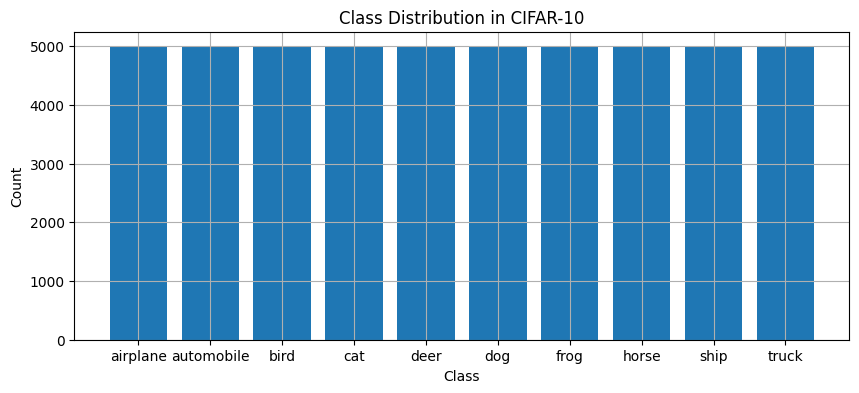

In [84]:
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter(labels)

plt.figure(figsize=(10,4))
plt.bar(class_names, [label_counts[i] for i in range(10)])
plt.title("Class Distribution in CIFAR-10")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


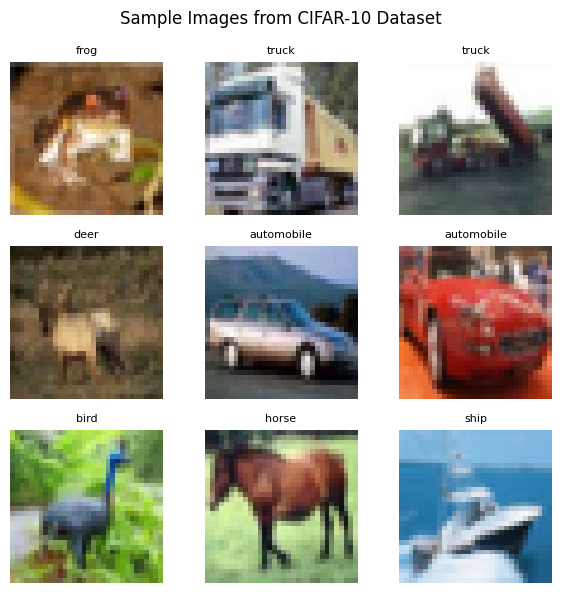

In [83]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(6,6))

for idx, ax in enumerate(axes.flatten()):
    img, label = cifar[idx]  
    ax.imshow(img)
    ax.set_title(class_names[label], fontsize=8)
    ax.axis("off")

plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=12)
plt.tight_layout()
plt.show()


In [82]:
import numpy as np

sizes = [np.array(cifar[i][0]).shape for i in range(500)]  # check 500 samples
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print("Image Resolution Stats:")
print("Unique resolutions:", set(sizes))
print("Average width:", np.mean(widths))
print("Average height:", np.mean(heights))


Image Resolution Stats:
Unique resolutions: {(32, 32, 3)}
Average width: 32.0
Average height: 32.0


###  Dataset Insights (CIFAR-10)

CIFAR-10 contains 60,000 images in 10 classes  
Each class has exactly 6,000 images → well balanced  
Image size is fixed at 32×32×3 (RGB)  
Classes include vehicles and animals  
Useful for training image classification and GAN models

From visual inspection:
- Colors and shapes vary a lot
- Low resolution makes it fast to train
- Balanced classes prevent bias
